### Week 1 - Properties of Time Series - Data, Filtering, Stationarity, ACF, PACF

### Packages, Importing Data

In [1]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import math
from math import sqrt
from math import isnan

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

<ipython-input-1-afe9cc16fbcd>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


### 1. Motivation

Generally, the motivation is forecasting and figuring out what might happen in the future, so you can make better decisions today.
*   Long-term: Climate Change (in 100 years)
*   Medium-term: Economic Forecasts (in 3-5 years)
*   Short-term: VaR (over 5 days), prices (15 minutes?)

What are the kind of possible sources from where a variable can be changed? 
1.    Change in its past value (AR component) e.g. AR. 
2.    Change in its determinants (DL component) e.g. ARMAX. 
3.    Occurance of some random event (MA component) e.g. MA. 
4.    Learning, detrioration or growth component (Trend).


### 2. Preliminary Steps: Looking at the Data and its Trend Properties

Before you do anything, you want to look at the data.

When doing so, you want to look at the properties of the data.

**Exanple: Australian macroeconomic data from Quarter 3 1969 - Quarter 1 2019**
*   Nominal GDP
*   Stock of money
*   Unemployment rate
*   CPI/prices
*   Short and long-term interest rates (3-month and 10-year Treasury bills)

Time series can differ in their trend behaviour. Nominal GDP and nominal money **smoothly** increase at **exponential rate**. 

Prices smoothly increase **linearly**. 

The unemployment rate increases in the **first half**, but decreases in the second half. In addition, in the first half, the **volatility is increasing**, then in the second half, the volatility is lower relative to the first.

Short and long-term interest rates have similar trends, where they are increasing in the first half and then a **large drop** and then **becomes relatively flat**. We also see that short-term interest rates are much more volatile than the long-term.

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

In [3]:
series = pd.read_csv('../data/raw/macro.csv', parse_dates = [0], date_parser = parser)
pd.options.display.float_format = '{:.2f}'.format
series.head()

,Date,CONS,NGDP,MONEY,PRICE,SHORT,LONG,URATE,WAGE,INVEST
0,1969-07-01,53230000000.00,8845000000.00,14200000000.00,8.82,5.90,5.80,1.70,NaN,18026000000.00
1,1969-10-01,53980000000.00,9061000000.00,14500000000.00,8.82,5.65,5.88,1.90,NaN,18334000000.00
2,1970-01-01,54361000000.00,9285000000.00,14700000000.00,8.92,6.42,5.99,1.60,NaN,18093000000.00
3,1970-04-01,54996000000.00,9642000000.00,15000000000.00,9.01,8.80,6.88,1.70,NaN,18502000000.00
4,1970-07-01,55703000000.00,9705000000.00,15000000000.00,9.10,6.85,6.88,1.70,NaN,18324000000.00


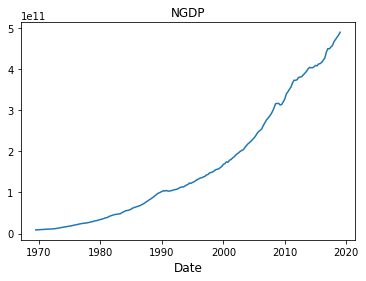

In [4]:
plt.plot(series['Date'], series['NGDP'])
graph = plt.xlabel('Date', fontsize=12)
graph = plt.title('NGDP', fontsize=12)

### 3. Combining Series, Mean Stationarity and Cointegration

We can also **combine** and create additional series. For example, Real GDP is defined as the nominal GDP divided by the price level. 

We notice that Real GDP and NGDP both trend upwards, but NGDP appears to be relatively more smooth.

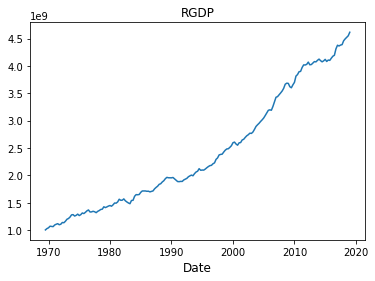

In [5]:
series['SPREAD'] = series['LONG'] - series['SHORT']
series['RGDP'] = series['NGDP']/series['PRICE']
plt.plot(series['Date'], series['RGDP'])
graph = plt.xlabel('Date', fontsize=12)
graph = plt.title('RGDP', fontsize=12)

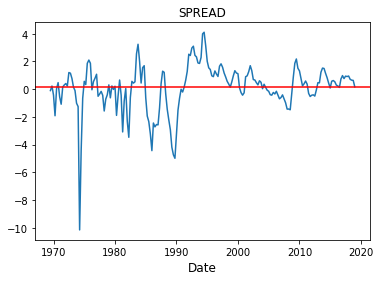

In [6]:
plt.plot(series['Date'], series['SPREAD'])
graph = plt.xlabel('Date', fontsize=12)
plt.axhline(y = series['SPREAD'].mean(), color = 'r', linestyle = '-')
graph = plt.title('SPREAD', fontsize=12)

Whilst the two individual series have trends, the spread is not trending. In other words, I can draw a horizontal line and say it hovers around or reverts back to this line. Formally, this series is **stationary in the mean**.

When you have two series that are non-stationary but the difference between them is stationary, that these series are **co-integrated**.



### 4. Methods to Achieve Stationarity: Combining and Filtering

We have **two ways** of obtaining series that are stationary from non-stationary series.


1.    We combine series and find co-integration
2.    We transform/filter out trends and changing volatility



### 5. Logarithmic Filters

Other than combining series, we can also **filter** or transform these series.

A common filter is the **logarithmic filter**, which is taking the natural log of a series. Why?
1.   Capture nonlinearities (turn non-linear trends into linear trends) i.e. If we can forecast the log of a variable, we can un-log it to forecast the variable itself!
2.   Correct for changing volatility (big movements are dampened more than smaller movements)

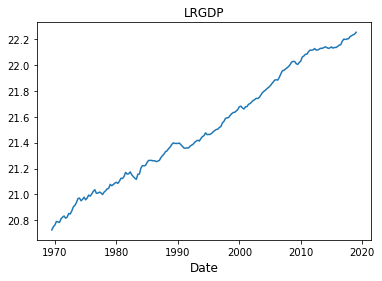

In [7]:
GDP = pd.DataFrame()
GDP['LRGDP'] = np.log(series['RGDP']) #Logging negative values is undefined
plt.plot(series['Date'], GDP['LRGDP'])
graph = plt.xlabel('Date', fontsize=12)
graph = plt.title('LRGDP', fontsize=12)

### 6. First and Second Difference Filters

A second important filter is the **first difference filter**, which takes the difference in the current and previous (past) value i.e. look at the change in the variable. 
>$\Delta y_t=y_t - y_{t-1}$

Why? We can now account for and remove trends, so that we can obtain stationarity in the mean.




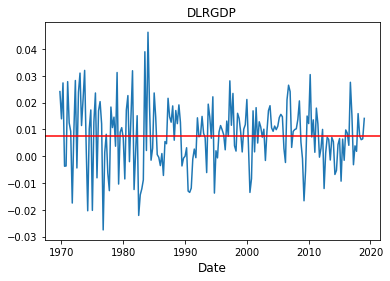

In [8]:
GDP['DLRGDP'] = GDP['LRGDP'].diff()
plt.plot(series['Date'], GDP['DLRGDP'])
graph = plt.xlabel('Date', fontsize=12)
plt.axhline(y = GDP['DLRGDP'].mean(), color = 'r', linestyle = '-')
graph = plt.title('DLRGDP', fontsize=12)

There are additional differencing filters e.g. **second difference filter** i.e. first difference of the first difference, can be performed in one step:

>$\Delta^2 y_t=\Delta y_t - \Delta y_{t-1}$
>$=y_t -2y_{t-1} + y_{t+2}$

Why second differencing? A lot of nominal macroeconomic data such as nominal price, wages, GDP, money, etc. generally requires differencing twice to achieve stationarity.

### 7. Seasonal Difference Filters

You can also do **seasonal difference filters**. Seasonality is when a variable is relatively high/low at certain times e.g. certain quarters of months. To account for his, you calculate the difference between the same month in different years for example.

If you had quarterly data, annual changes would involve difference the same quarter last year:
>$y_t - y_{t-4}$

If you had monthly data, you would do:
>$y_t - y_{t-12}$

Suppose you wanted to compute a weekly change with daily data would involve:
>$y_t - y_{t-5}$

### 8. Moving Average (MA) Filters

There are also **Moving Average filters**. This has an effect of smoothing fluctuations in the data.

Third order MA filter averages 3 observations:
>$MA(3) = (y_t + y_{t-1} + y_{t-2})/3$

Fifth order MA filter averages 5 observations:
>$MA(5) = (y_t + y_{t-1} + y_{t-2} + y_{t-3} + y_{t-4})/5$

Moving averages are often **centered**.
>$MA(3) = (y_{t+1} + y_{t} + y_{t-1})/3$



### 9. Power Filters

The **square filter** is used to **detect changes in volatility** in financial markets because you go from mean to variance analysis:
>$x_t = y^2_t$

The **cubic filter** is used to detect changes in **skewness** over time:
>$x_t = y^3_t$

The **quartic filter** is used to detect changes in **kurtosis** over time:
>$x_t = y^4_t$


### Filter Examples

In [9]:
spread = pd.DataFrame()
#First-difference filter
spread['DSPREAD'] = series['SPREAD'].diff()
#Second-difference filter
spread['D2SPREAD'] = spread['DSPREAD'].diff()
#Seasonal-difference filter (annual change)
spread['SPREAD_SEASONAL'] = series['SPREAD'][4:] - series['SPREAD'][:-4]
#3rd order moving average (MA) filter
spread['SPREAD_MA3'] = (series['SPREAD'][2:] + series['SPREAD'][1:-1] + series['SPREAD'][:-2])/3
#Square filter (volatility)
spread['SPREAD_P2'] = (series['SPREAD'])**2
#Cubic filter (skewness)
spread['SPREAD_P3'] = (series['SPREAD'])**3
#Quartic filter (kurtosis)
spread['SPREAD_P4'] = (series['SPREAD'])**4
#Squared demeaned filter
spread['SPREAD2'] = (series['SPREAD'] - series['SPREAD'].mean())**2
#Absolute demeaned filter
spread['SPREAD_ABS'] = abs(series['SPREAD'] - series['SPREAD'].mean())
#2-period moving sum filter
spread['SPREAD3'] = series['SPREAD'][1:] + series['SPREAD'][:-1]
#Log filter
spread['LSPREAD'] = np.log(series['SPREAD']) #Logging negative values is undefined

C:\Users\Max Ruan\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 10. Lag Operators

We define L as the lag operator. A convenient way to represent filters and combining filters.

1 lag:
>$y_{t-1} = Ly_t$

2 lags:
>$y_{t-2} = L^2y_t$

k lags:
>$y_{t-k} = L^ky_t$

Thus, a first difference filter using lag operators is:
>$y_t - y_{t-1} = y_t - Ly_t = (1-L)y_t$

It is also possible to have future values represented, using negative values of k:
>$y_{t+k} = L^{-k}y_t$

Useful for centered MA(3) filters for example.

### 11. Stationarity and Methods to Identify Stationarity

(Covariance) Stationarity is an important concept in time series analysis. 

3 ways to identify stationarity:
1.   Graphical 

*   If the series **reverts around a horizontal line**, it is **stationary in the mean**, if the series' **volatility is constant over time**, it is **stationary in the variance**
*   If it trends up or downwards, not stationary
*   If volatility increases or decreases over the sample, not stationary



2.   Statistical 
*   If the **unconditional moments** i.e. mean, variance (specific case) and autocovariances (general case) are **not a function of time**
*   $\mu = E(y_t)\neq f(t)$
*   $\gamma_0 = E(y_t - \mu)^2\neq f(t)$
*   $\gamma_k = E(y_t - \mu)(y_{t-k}-\mu)\neq f(t)$
3.   Impulse Analysis

*   We check if a shock in the series eventually dies out 
*   Consider the AR(1) model: $y_t = \phi_0 + \phi_1 y_{t-1} + u_t$
*   The effect pf a shock $u_t$ on $y_t$ is 1-to-1 i.e. If the shock is equal to positive 1, this increases $y_t$ by 1
*    In the next period, $y_{t+1} = \phi_0 + \phi_1 y_{t} + u_{t+1}$, this tells us that the effect of $u_t$ on $y_{t+1}$ is $\phi_1$
*    We should expect that $\phi_0 < 1$ where it has a **diminishing effect** on $y_t$ if it is **stationary**

We typically look at covariance stationarity (first 2 moments are stationary). Strict stationary if all of the momennts are stationary. 

If a series is normally distributed, then it is strictly stationary if it is covariance stationary (because the distribution is defined by only 2 moments). 

Nonstationarity means if one of the moments (mean or variance) are functions of time.

**Why do we care about having stationarity?** We want to know what a variable's expected value, variance and correlation between other variable in different periods. 
We calculate this using a mean across many time periods - but this is only informative if the expected value is the same across those time periods. If everything is different in the past, then its impossible to forecast tomorrow. But if we find something that is the same in the past, then we may know that its the same in the future.

Stationarity requires a finite and time-invariant mean, variance and covariance. Non-stationarities can come from deterministic changes (like trend, seasonality/cycles) or stochastic properties (like unit root). Non-stationarity data as a rule are unpredictable and cannot be modeled or forecasted. Results obtained by using non-stationary time seires may be spurious/useless. Hence, non-stationary data may need to be transformed into stationary data through filtering methods.

A unit root implies non-stationarity (even if the process is stationarity in the mean). This is because the moments of the process depend on time and are thus time-varying. For example, if we have an AR(1) process where we have a unit root, the variance of the process at 't' is equal to the unconditional variance multiplied by 't'. Note that the variance of the series is diverging to infinity with 't'.

How to identify non-stationarity? 1. Deterministic trends can be identified visually and can be taken into account using detrending it (-beta times t).

1. Graphical: Is there a trend? Do you see if variances are different in different periods? Check the random subperiod tests. 2. Check if there is no unit root (1 type of non-stationarity). 3. Check KPSS test for evidence against stationarity. 4. Check ACF rapid decay. Make overall weighted average conclusions.


### 12. Autocorrelation Function (ACF) and Statistically Testing for ith Order Autocorrelation 

The ACF computes the correlation between a variable itself $p$ lags ago.

Done by running the regression (OLS):
$y_t = \phi_0 +\phi_1 y_{t-i} +u_t$

Where $u_t$ is the error term, normally distributed $u_t \sim N(0,\sigma^2_u)$

We obtain the sample autocorrelation estimate $\hat  \phi_i $

The ACF runs the regression for 1 lag, 2 lags, 3 lags,... and collects the correlations ($\phi_i$ parameters) and plots it against each lag. 

We would want to test if the coefficients are statistically significant. 
*   Null: $H_0:\phi_i = 0$
*   Alternative: $H_0: \phi_i \ne 0$

The sample autocorrelations are distributed asymptotically as $\hat  \phi_i \sim N(0,1/T)$ where $T$ is the sample size.

The test statistic is thus:

$\sqrt{T} \hat  \phi_i \sim N(0,1)$

At the 5% level, the critical value is 1.96 (p-value is 0.05). If the test statistic is greater than 1.96 (p-value is less than 0.05) than we reject the null at the 5% level and choose the alternative hypothesis.

In regards to the ACF, a **stationary process should exhibit a rapidly decaying ACF**. We may see if a series is non-stationary if it does not converge to 0 or if it does not converge at a 'rapid enough' rate.



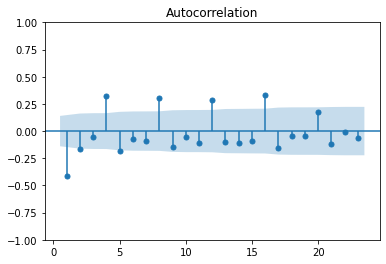

In [10]:
variable = spread['D2SPREAD']
acfplot = plot_acf(variable[pd.Series.first_valid_index(variable):], alpha = .05, zero = False)

In [11]:
acfresults = acf(variable[pd.Series.first_valid_index(variable):], nlags = 30, qstat = True, alpha = .05)
pacfresults = pacf(variable[pd.Series.first_valid_index(variable):], nlags = 30, method = 'ols', alpha = .05)
correlogram = pd.DataFrame(columns = ['Lag','AC', 'PAC', 'Q-Statistic', 'P-Value'])
np.set_printoptions(precision=3, suppress=True)
correlogram['Lag'] = range(1, 31)
correlogram['AC'] = acfresults[0][1:]
correlogram['PAC'] = pacfresults[0][1:]
correlogram['Q-Statistic'] = acfresults[2]
correlogram['P-Value'] = acfresults[3]
pd.options.display.float_format = '{:.4f}'.format
print("Critical value ACF 5% level: {:.4f}".format(1.96/(len(variable))**0.5))
correlogram.head()

Critical value ACF 5% level: 0.1389


,Lag,AC,PAC,Q-Statistic,P-Value
0,1,-0.4099,-0.4101,33.6129,0.0000
1,2,-0.1632,-0.3997,38.9676,0.0000
2,3,-0.0557,-0.4431,39.5947,0.0000
3,4,0.3245,-0.0081,60.9845,0.0000
4,5,-0.1809,-0.0891,67.6693,0.0000


### 13. Partial Autocorrelation Function (PACF) and Partial Autocorrelation Test

The PACF computes the correlation between a variable itself $p$ lags ago, **given that intermediate lags are included**.

Done by running the regression (OLS):
$y_t = \phi_0 +\phi_{1i} y_{t-1} + \phi_{2i} y_{t-2} + ... + \phi_{pi} y_{t-p}  +u_t$

Where $u_t$ is the error term, normally distributed $u_t \sim N(0,\sigma^2_u)$

We obtain the sample autocorrelation estimate $\hat  \phi_{ii} $

The ACF runs the regression for 1 lag, 2 lags, 3 lags,... and collects the correlations ($\phi_{ii}$ parameters) and plots it against each lag. 

We would want to test if the coefficients are statistically significant. 
*   Null: $H_0:\phi_{ii} = 0$
*   Alternative: $H_0: \phi_{ii} \ne 0$

The sample autocorrelations are distributed asymptotically (the same as ACF regression) as $\hat  \phi_i \sim N(0,1/T)$ where $T$ is the sample size.

The test statistic is thus:

$\sqrt{T} \hat  \phi_i \sim N(0,1)$

At the 5% level, the critical value is 1.96 (p-value is 0.05). If the test statistic is greater than 1.96 (p-value is less than 0.05) than we reject the null at the 5% level and choose the alternative hypothesis.

A PACF is good for telling us what order AR process may best fit the series.

We think of ACF and PACF as **prelimary checks** of the series before thinking about modelling.

C:\Users\Max Ruan\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


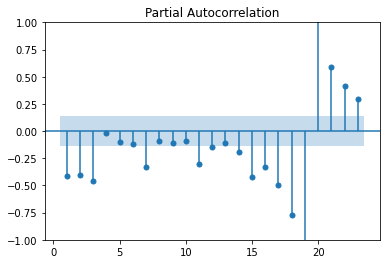

In [12]:
pacfplot = plot_pacf(variable[pd.Series.first_valid_index(variable):], alpha = .05, zero = False)

### 14. Slutsky Effect and Long Swing Hypothesis

Long Swing Hypothesis: A lot of economic variables seem to exhibited a very long cycle (of 20 years), identified by applying 2 filters (5-year MA and 5-year centered first difference). The lessons are to be **weary of MA filters**. Expanding the lag operators, we see that the effective filter is a restricted centered **15-year MA filter**. 

The issue is that a (random) white noise process (simulated from N(0,1)) after applying this filter appears to have **strong evidence of cycles!**  

ACF and PACF: Original series both have flat results. We see cyclical results in ACF and significant spikes in PACF. i.e. Cycles were generated from the filters he used. 